<a href="https://colab.research.google.com/github/ElisabethShah/DS-Unit-2-Tree-Ensembles/blob/master/module1-decision-trees/Decision%20Trees%20-%20Assignment%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science_

This sprint, your project is about water pumps in Tanzania. Can you predict which water pumps are faulty?

# Decision Trees

#### Objectives
- clean data with outliers
- impute missing values
- use scikit-learn for decision trees
- understand why decision trees are useful to model non-linear, non-monotonic relationships and feature interactions
- get and interpret feature importances of a tree-based model

#### Links

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)

### Libraries


#### category_encoders

You aren't required to use [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding), but it's recommended.

If you're working locally, you already installed it, probably with this shell command: `conda install -c conda-forge category_encoders` 

If you're using Google Colab, you need to reinstall it every time you restart all runtimes: `pip install category_encoders`

#### graphviz

This also isn't required to do your assignment, but it's used in the lecture notebook, to visualize decision trees.

If you're working locally with Anaconda, use this shell command: `conda install python-graphviz`

If you're using Google Colab, use this command:  `!pip install graphviz` 


## Install dependencies, import libraries

In [1]:
!pip install category_encoders

In [2]:
!pip install -U pandas-profiling

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

## Load Data

In [4]:
LOCAL = '../data/tanzania/'
WEB = ('https://raw.githubusercontent.com/LambdaSchool/'
       'DS-Unit-2-Tree-Ensembles/master/data/tanzania/')
source = WEB

train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))

test = pd.read_csv(source + 'test_features.csv')

sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

### Features

Your goal is to predict the operating condition of a waterpoint for each record in the dataset. You are provided the following set of information about the waterpoints:

- `amount_tsh` : Total static head (amount water available to waterpoint)
- `date_recorded` : The date the row was entered
- `funder` : Who funded the well
- `gps_height` : Altitude of the well
- `installer` : Organization that installed the well
- `longitude` : GPS coordinate
- `latitude` : GPS coordinate
- `wpt_name` : Name of the waterpoint if there is one
- `num_private` :  
- `basin` : Geographic water basin
- `subvillage` : Geographic location
- `region` : Geographic location
- `region_code` : Geographic location (coded)
- `district_code` : Geographic location (coded)
- `lga` : Geographic location
- `ward` : Geographic location
- `population` : Population around the well
- `public_meeting` : True/False
- `recorded_by` : Group entering this row of data
- `scheme_management` : Who operates the waterpoint
- `scheme_name` : Who operates the waterpoint
- `permit` : If the waterpoint is permitted
- `construction_year` : Year the waterpoint was constructed
- `extraction_type` : The kind of extraction the waterpoint uses
- `extraction_type_group` : The kind of extraction the waterpoint uses
- `extraction_type_class` : The kind of extraction the waterpoint uses
- `management` : How the waterpoint is managed
- `management_group` : How the waterpoint is managed
- `payment` : What the water costs
- `payment_type` : What the water costs
- `water_quality` : The quality of the water
- `quality_group` : The quality of the water
- `quantity` : The quantity of water
- `quantity_group` : The quantity of water
- `source` : The source of the water
- `source_type` : The source of the water
- `source_class` : The source of the water
- `waterpoint_type` : The kind of waterpoint
- `waterpoint_type_group` : The kind of waterpoint

### Labels

There are three possible values:

- `functional` : the waterpoint is operational and there are no repairs needed
- `functional needs repair` : the waterpoint is operational, but needs repairs
- `non functional` : the waterpoint is not operational

## Clean data with outliers, impute missing values (example solutions)

In [0]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

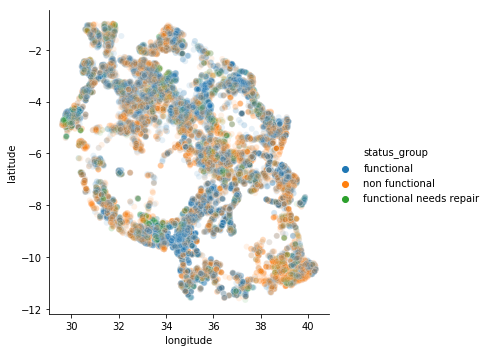

In [6]:
# Check updated location (lat/long) values.
sns.relplot(x='longitude', y='latitude', hue='status_group', 
            data=train, alpha=0.1);

## Select features

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [16]:
cardinality.sort_values(ascending=False)

wpt_name                 30661
subvillage               17232
scheme_name               2564
ward                      2082
installer                 1930
funder                    1717
date_recorded              349
lga                        124
region                      21
extraction_type             18
extraction_type_group       13
scheme_management           13
management                  12
source                      10
basin                        9
water_quality                8
extraction_type_class        7
waterpoint_type              7
source_type                  7
payment                      7
payment_type                 7
waterpoint_type_group        6
quality_group                6
management_group             5
quantity                     5
permit                       3
source_class                 3
public_meeting               3
recorded_by                  1
dtype: int64

In [8]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year_recorded
count,47520.000000,47520.000000,47520.000000,46078.000000,46078.000000,47520.000000,47520.000000,47520.000000,47520.000000,31003.000000,47520.000000
mean,37037.915699,321.925261,669.567656,35.149033,-5.884512,0.477736,15.258291,5.616751,179.805513,1996.825469,2011.921907
std,21412.099719,3197.240487,693.005745,2.604241,2.805599,13.312977,17.530228,9.621230,463.081564,12.499247,0.959690
min,0.000000,0.000000,-63.000000,29.607122,-11.649440,0.000000,1.000000,0.000000,0.000000,1960.000000,2002.000000
25%,18482.750000,0.000000,0.000000,33.284679,-8.633876,0.000000,5.000000,2.000000,0.000000,1988.000000,2011.000000
50%,36986.500000,0.000000,372.500000,35.008578,-5.170151,0.000000,12.000000,3.000000,25.000000,2000.000000,2012.000000
75%,55450.250000,25.000000,1320.000000,37.223501,-3.375068,0.000000,17.000000,5.000000,215.000000,2008.000000,2013.000000
max,74247.000000,350000.000000,2770.000000,40.344301,-0.998464,1776.000000,99.000000,80.000000,15300.000000,2013.000000,2013.000000


In [0]:
ward_locations = train[['lga', 'ward', 'latitude', 'longitude']]
ward_locations = ward_locations.groupby(['lga', 'ward']).median()
ward_locations = ward_locations.reset_index()

In [20]:
ward_locations.describe(include='all')

,lga,ward,latitude,longitude
count,2181,2181,2117.000000,2117.000000
unique,124,2082,NaN,NaN
top,Nzega,Majengo,NaN,NaN
freq,37,4,NaN,NaN
mean,NaN,NaN,-5.745423,35.214959
std,NaN,NaN,2.862085,2.674458
min,NaN,NaN,-11.511758,29.616872
25%,NaN,NaN,-8.140355,33.124124
50%,NaN,NaN,-5.069722,35.113614
75%,NaN,NaN,-3.385606,37.516797


In [28]:
ward_locations[ward_locations['ward']=='Majengo']

,lga,ward,latitude,longitude
582,Kigoma Urban,Majengo,-4.905174,29.675457
1308,Moshi Urban,Majengo,-3.340757,37.353457
1385,Mtwara Urban,Majengo,-10.284824,40.191619
1423,Muheza,Majengo,-5.175606,38.800020


In [26]:
train[train['ward'] == 'Badugu']['latitude']

6894    NaN
17242   NaN
5363    NaN
38458   NaN
53552   NaN
18250   NaN
50205   NaN
50240   NaN
51776   NaN
51644   NaN
14650   NaN
7952    NaN
44239   NaN
22773   NaN
3734    NaN
Name: latitude, dtype: float64